# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [2]:
df = df.drop('diagnosis',axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
more = ['Unnamed: 32','id']
df = df.drop(more,axis = 1 )
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.dtypes

radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst       float64
symmetry_worst      

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
# Perform K-Means Clustering on the Dataset

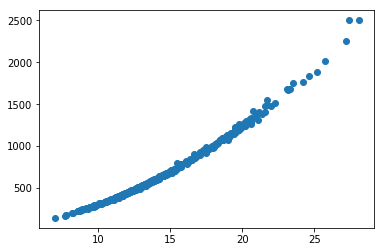

In [6]:
plt.scatter(df['radius_mean'], df['area_mean']);

In [0]:
test = df[['radius_mean', 'area_mean']].copy()

In [8]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(test)
labels = kmeans.labels_

print(labels)

[0 2 2 1 2 1 0 1 1 1 0 0 2 0 1 0 0 0 2 1 1 1 0 2 0 0 0 2 0 0 2 1 0 2 0 0 0
 1 0 1 1 1 2 1 1 2 1 1 1 1 1 1 1 0 0 1 2 0 1 1 1 1 0 1 1 0 1 1 1 1 2 1 0 1
 1 0 1 0 2 1 1 1 2 2 1 2 0 2 1 0 0 0 1 1 0 2 1 1 1 0 1 1 1 1 1 1 1 1 2 1 1
 1 0 1 1 1 1 0 0 0 1 2 2 0 1 1 1 2 0 2 1 0 0 0 2 1 1 1 0 1 1 0 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 0 1 1 1 2 2 1 2 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 2 2 0 1 0
 1 0 1 1 1 0 1 1 1 0 1 1 0 2 0 1 0 2 1 1 0 1 0 1 0 2 1 2 0 0 1 1 1 2 2 1 1
 1 0 1 0 1 0 1 1 0 1 1 2 1 0 2 2 0 0 1 1 1 1 2 1 1 1 1 1 2 1 2 0 2 0 2 0 0
 0 2 0 0 0 0 2 1 1 1 1 0 1 2 1 0 1 1 2 1 1 2 1 2 0 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 1 2 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 2 1 2 1 1 0 1 0 0 0 1 1
 1 1 0 1 2 1 2 0 1 1 2 1 1 1 0 1 1 1 0 2 0 1 1 1 1 1 1 1 1 1 0 1 2 2 1 2 2
 0 0 2 2 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 0 2 1 0 1 1 1 1 0 1 1 1 1 1 0
 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 2 2 0 0 1 0 1 0 1 0 1 1
 0 1 0 0 0 2 1 2 1 0 1 1 1 1 1 1 0 2 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 1
 0 1 1 0 1 0 2 1 0 1 0 0 

In [9]:
kmeans.cluster_centers_

array([[  15.675     ,  766.16644737],
       [  11.77987688,  432.49429429],
       [  20.6325    , 1335.16666667]])

In [10]:
# Add our new labels to the dataframe
test_series = pd.Series(labels)
test['clusters'] = test_series.values

test.head()

,radius_mean,area_mean,clusters
0,17.99,1001.0,0
1,20.57,1326.0,2
2,19.69,1203.0,2
3,11.42,386.1,1
4,20.29,1297.0,2


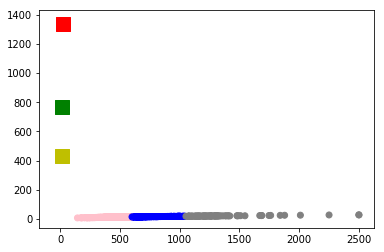

In [13]:
LABEL_COLOR_MAP = {0 : 'blue',
                   1 : 'pink',
                   2:'gray'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(test['area_mean'], test['radius_mean'], c=label_color)

plt.scatter(15.675     ,  766.16644737, s=200, c='g', marker='s')
plt.scatter(20.6325    , 1335.16666667, s=200, c='r', marker='s')
plt.scatter(11.77987688,  432.49429429, s=200, c='y', marker='s')

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
# Your Code Here

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [14]:
#first std the data
features=df.columns
features

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [0]:
#STD here
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [0]:
#apply pca
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [0]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(principalDf)
    sum_of_squared_distances.append(km.inertia_)

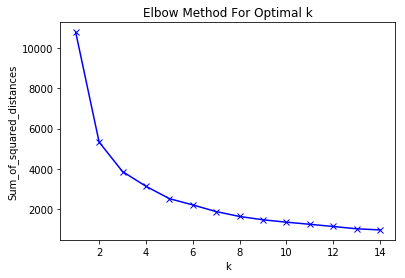

In [18]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
principalDf.head()

,principal component 1,principal component 2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072


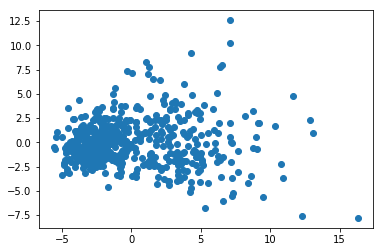

In [20]:
plt.scatter(principalDf['principal component 1'],principalDf['principal component 2']);

In [21]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(principalDf)
labels = kmeans.labels_

print(labels)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

In [22]:
#coor for the final position of cluster dots
kmeans.cluster_centers_

array([[ 4.35883027,  0.04297744],
       [-2.20247773, -0.02171612]])

In [23]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
principalDf['clusters'] = new_series.values

principalDf.head()

,principal component 1,principal component 2,clusters
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0


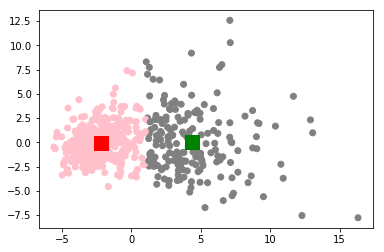

In [25]:

LABEL_COLOR_MAP = {0 : 'gray',
                   1 : 'pink',
                   2:'blue'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=label_color)
#take results from cluster center and paste them here repeat code for whatever you n_cluster equals
plt.scatter(4.35883027,  0.04297744, s=200, c='g', marker='s')
plt.scatter(-2.20247773, -0.02171612, s=200, c='r', marker='s')
plt.show()

In [0]:
#90 percent
#apply pca
pca = PCA(n_components=9)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['cp1', 'cp2','cp3','cp4','cp5','cp6','cp7','cp8','cp9'])

In [27]:
principalDf.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411425,2.159370,-0.398411,-0.157103
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240991,-0.711917
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097371,0.024044
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053421,1.429912,1.059564,-1.405477
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226494,-0.936213,0.636377,-0.263795


In [28]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(principalDf)
labels = kmeans.labels_

print(labels)

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

In [35]:
#coor for the final position of cluster dots
KMeans(n_clusters=9)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
# Add our new labels to the dataframe
new_series = pd.Series(labels)
principalDf['clusters'] = new_series.values

principalDf.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,clusters
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411425,2.159370,-0.398411,-0.157103,0
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240991,-0.711917,0
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097371,0.024044,0
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053421,1.429912,1.059564,-1.405477,0
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226494,-0.936213,0.636377,-0.263795,0


In [0]:
LABEL_COLOR_MAP = {0 : 'gray',
                   1 : 'pink',
                   2:'blue'
                   }

label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=label_color)
#take results from cluster center and paste them here repeat code for whatever you n_cluster equals
plt.scatter(4.35883027,  0.04297744, s=200, c='g', marker='s')
plt.scatter(-2.20247773, -0.02171612, s=200, c='r', marker='s')
plt.show()

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project